In [9]:
# Set up autoreload and inline plotting for Jupyter Notebook
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
! git clone https://github.com/mikonvergence/DiffusionFastForward

fatal: destination path 'DiffusionFastForward' already exists and is not an empty directory.


In [3]:
!pip install pytorch-lightning==1.9.3 diffusers einops kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.4/826.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 833.3/833.3 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6

In [4]:
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append('./DiffusionFastForward/')

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from DiffusionFastForward.src import *

mpl.rcParams['figure.figsize'] = (8, 8)

**Data preperation**

Here we use the Datasets library to easily load the CIFAR-10 dataset from the hub. This dataset consists of images which already have the same resolution, namely 32x32. We are downloading the train and test set.

In [11]:
import torchvision.datasets as datasets
import pickle
import os
from PIL import Image
import numpy as np

# Download the CIFAR-10 dataset
datasets.CIFAR10(root='./CIFAR10', train=True, download=True)
datasets.CIFAR10(root='./CIFAR10', train=False, download=True)

# Function to unpickle CIFAR-10 data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify output directories
train_output_dir = './CIFAR10_train_images'
test_output_dir = './CIFAR10_test_images'
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

# Load all CIFAR-10 training data batches
train_data = []
train_labels = []
for i in range(1, 6):
    batch = unpickle(f'./CIFAR10/cifar-10-batches-py/data_batch_{i}')
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Concatenate all training data and labels
train_data = np.concatenate(train_data, axis=0)
train_labels = np.array(train_labels)

# Reshape training data to (num_samples, channels, height, width)
train_data = train_data.reshape((len(train_data), 3, 32, 32)).transpose(0, 2, 3, 1)

# Load the test data batch
test_batch = unpickle('./CIFAR10/cifar-10-batches-py/test_batch')
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']

# Reshape test data to (num_samples, channels, height, width)
test_data = test_data.reshape((len(test_data), 3, 32, 32)).transpose(0, 2, 3, 1)

# Load batches.meta to get label names
meta = unpickle('./CIFAR10/cifar-10-batches-py/batches.meta')
label_names = [name.decode('utf-8') for name in meta[b'label_names']]

# Save each training image as JPEG
for idx in range(len(train_data)):
    img_array = train_data[idx]
    label = label_names[train_labels[idx]]
    img = Image.fromarray(img_array)
    img.save(os.path.join(train_output_dir, f'image_{idx}_label_{label}.jpg'))

# Save each test image as JPEG
for idx in range(len(test_data)):
    img_array = test_data[idx]
    label = label_names[test_labels[idx]]
    img = Image.fromarray(img_array)
    img.save(os.path.join(test_output_dir, f'image_{idx}_label_{label}.jpg'))

print(f"Saved {len(train_data)} training images to {train_output_dir}")
print(f"Saved {len(test_data)} test images to {test_output_dir}")


Files already downloaded and verified
Files already downloaded and verified
Saved 50000 training images to ./CIFAR10_train_images
Saved 10000 test images to ./CIFAR10_test_images


In [20]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 num_images=None,
                 paired=False,
                 sort_files=False,
                 return_pair=False
                 ):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair

        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )

        # check files
        supported_formats=['jpg']
        if num_images:
            self.files=[el for el in os.listdir(self.root_dir)[:num_images]  if el.split('.')[-1] in supported_formats]
        else:
            self.files=[el for el in os.listdir(self.root_dir)  if el.split('.')[-1] in supported_formats]
        # sort files if required
        if sort_files:
            self.files.sort()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image2,image
        else:
            return image

**Image preprocessing**

Next, we define some transformations with inp_T variable which we'll apply on-the-fly on the entire dataset. We pass this variable to the SimpleImageDataset class which uses augmemtation from Kornia library to apply the transformations.
The transformations include:
 - random horizontal flips with probability 1,
 - random crop size 32x32,
 - rescaling and finally make them have values in the [−1,1] range (This is done through the framework with the PixelDiffusion Class).

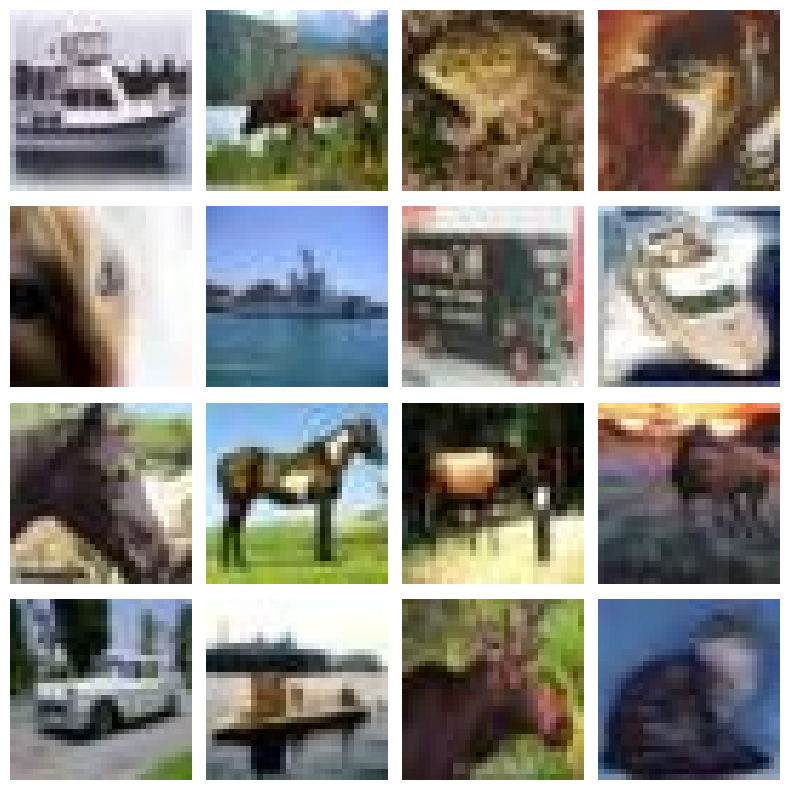

In [22]:
CROP_SIZE=32
PROBABILITY = 1
inp_T=[
      # KA.Resize((CROP_SIZE,CROP_SIZE)),
       KA.RandomHorizontalFlip(p=PROBABILITY),
    ]

train_ds=SimpleImageDataset('./CIFAR10_train_images',
                            transforms=inp_T
                     )
test_ds=SimpleImageDataset('./CIFAR10_test_images',
                            transforms=inp_T)
for idx in range(16):
    plt.subplot(4,4,1+idx)
    plt.imshow(train_ds[idx].permute(1,2,0))
    plt.axis('off')
plt.tight_layout()


**Train the model**

In [ ]:
model=PixelDiffusion(train_dataset=train_ds,
                     lr=1e-3,
                     valid_dataset=test_ds,
                     num_timesteps=1000,
                     batch_size=128)

Is Time embed used ?  True


In [ ]:
trainer = pl.Trainer(
    max_steps=28140,
    callbacks=[EMA(0.9999)],
    gpus = 1

)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params
----------------------------------------------------
0 | model | DenoisingDiffusionProcess | 56.6 M
----------------------------------------------------
56.6 M    Trainable params
0         Non-trainable params
56.6 M    Total params
226.463   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=14070` reached.


**Generate new samples**

In [ ]:
B=64 # number of samples

model.cuda()
out=model(batch_size=B,shape=(32,32),verbose=True)

diffusion sampling:   0%|          | 0/400 [00:00<?, ?it/s]

**Show all samples**

In [ ]:

for idx in range(out.shape[0]):
    plt.subplot(1,len(out),idx+1)
    image_np = out[idx].detach().cpu().permute(1, 2, 0).numpy()
    # Clip image data to [0, 1] range
    image_np = image_np.clip(0, 1)
    plt.imshow(image_np)
    plt.axis('off')

**Show sample with specific index**

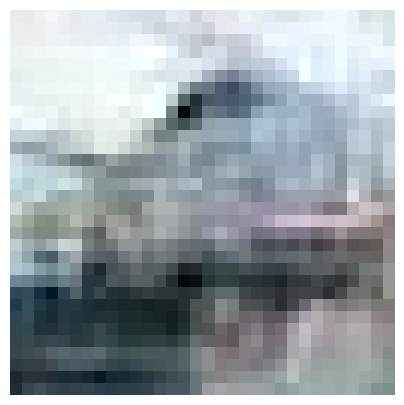

In [ ]:
# Display the sample with index 1
idx = 16 # Index of the sample you want to display

# Create a single subplot for the sample with index 1
plt.figure(figsize=(5, 5))
image_np = out[idx].detach().cpu().permute(1, 2, 0).numpy()

# Clip image data to [0, 1] range
image_np = image_np.clip(0, 1)

# Display the image
plt.imshow(image_np)
plt.axis('off')
plt.show()

**Show samples in 4x4 grid**

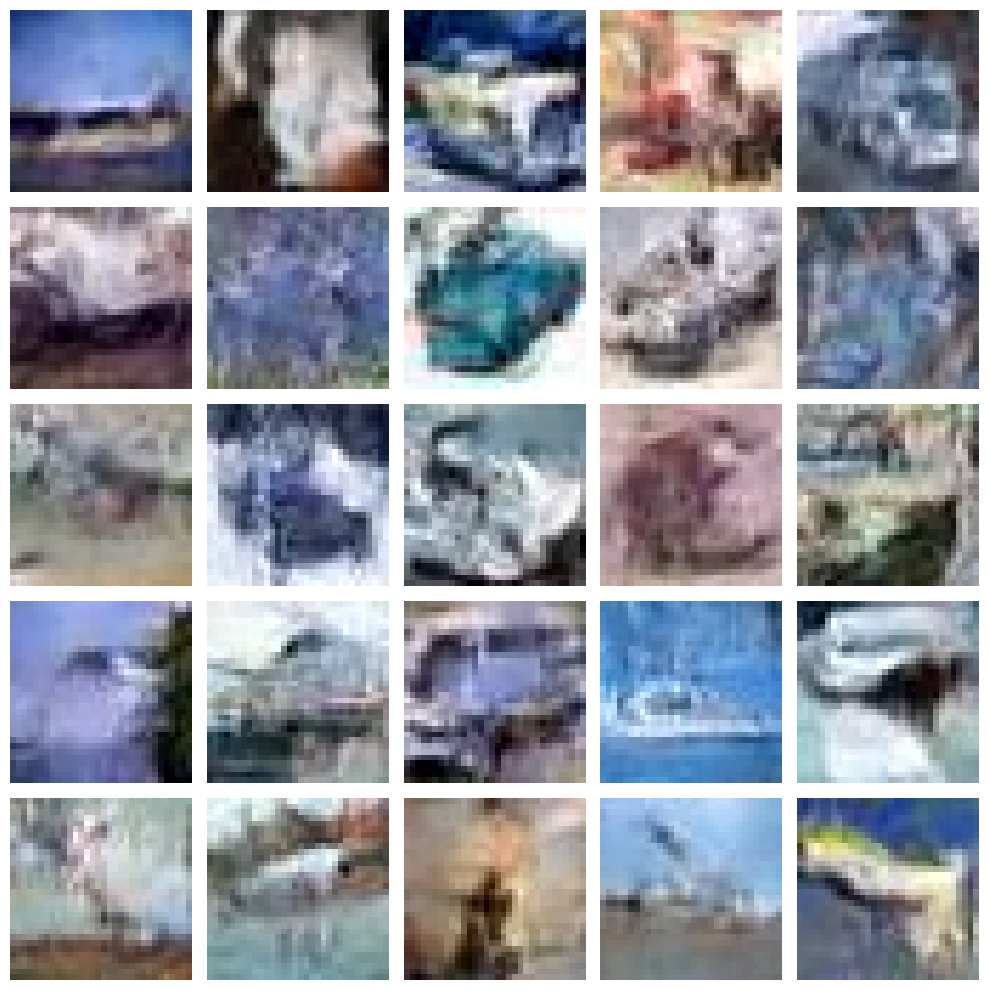

In [ ]:
# Number of samples to display
num_samples = 25

# Create a 4x4 subplot grid
fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for i in range(num_samples):
    # Determine the position in the grid
    ax = axs[i // 5, i % 5]
    image_np = out[i].detach().cpu().permute(1, 2, 0).numpy()

    # Clip image data to [0, 1] range
    image_np = image_np.clip(0, 1)

    # Display the image
    ax.imshow(image_np)
    ax.axis('off')

plt.tight_layout()
plt.show()